# Selecting the number of clusters in K-means 
This example is based on
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
<br>
&
<br>
Peter J. ROUSSEEUW,  "Silhouettes: A graphical aid to the interpretation and validation of cluster analysis," Journal of Computational and Applied Mathematics 20 (1987) 53-65.

## Table of contents

<a href="#setup">1. Setup</a>

<a href="#create_data">2. Create data</a>

<a href="#kmeans">3. K-means</a>

<a href="#plot_results">4. Plot clusters and metrics</a>

<a id="setup"></a>
# 0. Setup

In [ ]:
%load_ext sql

In [ ]:
# Greenplum Database 5.x on GCP (PM demo machine) - direct external IP access
#%sql postgresql://gpadmin@34.67.65.96:5432/madlib

# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

In [ ]:
%sql select madlib.version();
#%sql select version();

<a id="create_data"></a>
# 1. Create data
Make blobs

Automatically created module for IPython interactive environment


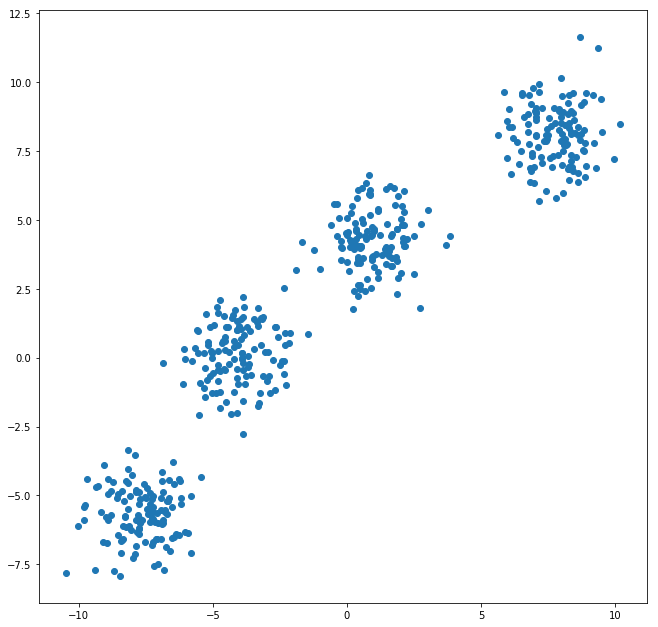

In [34]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_blobs

plt.figure(figsize=(24, 24))

X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1.0,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=3)  # For reproducibility

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1])

Write out to database table via Pandas

In [35]:
import pandas as pd
from sqlalchemy import create_engine

# Make a Pandas list of lists
X_flat = [w.flatten() for w in X]
Xd = pd.DataFrame([[x.tolist()] for x in X_flat], columns=['points'])

# Create table
%sql DROP TABLE IF EXISTS km_sample1;
%sql CREATE TABLE km_sample1 (pid integer, points double precision[]);

#engine = create_engine('postgresql://fmcquillan@localhost:5432/madlib')
#engine = create_engine('postgresql://gpadmin@34.67.65.96:5432/madlib')
engine = create_engine('postgresql://gpadmin@localhost:8000/madlib')

Xd.to_sql('km_sample1', engine, index_label='pid', if_exists='append')

# Show sample
%sql SELECT * FROM km_sample1 ORDER BY pid LIMIT 10;

Done.
Done.
10 rows affected.


pid,points
0,"[8.15601180576535, 7.71811327659842]"
1,"[2.10536759967781, 4.18687847417101]"
2,"[10.1636881328864, 8.4809751834587]"
3,"[7.91872957232674, 8.25809924402385]"
4,"[-4.09118844871247, -2.00086550708339]"
5,"[-9.81299262139986, -5.4051225671586]"
6,"[-3.12408401467883, 1.47875530312673]"
7,"[7.06327151382083, 8.87499561852479]"
8,"[9.48805106025659, 9.36935354360064]"
9,"[7.13956902442378, 7.62758573800053]"


<a id="kmeans"></a>
# 2.  K-means
Run one of the K-means algorithms to find the cluster centers.

K-means++

In [36]:
%%sql
DROP TABLE IF EXISTS k_auto, k_auto_summary;

SELECT madlib.kmeanspp_auto(
    'km_sample1',                  -- points table
    'k_auto',                      -- output table
    'points',                      -- column name in point table
    ARRAY[2,3,4,5,6],              -- k values to try
    'madlib.squared_dist_norm2',   -- distance function
    'madlib.avg',                  -- aggregate function
    20,                            -- max iterations
    0.001,                         -- minimum fraction of centroids reassigned to continue iterating
    1.0,                           -- centroid seed
    'both'                         -- k selection algorithm (silhouette and elbow)
);

Done.
1 rows affected.


kmeanspp_auto
""


or
K-means random

%%sql
DROP TABLE IF EXISTS k_auto, k_auto_summary;

SELECT madlib.kmeans_random_auto(
    'km_sample1',                  -- points table
    'k_auto',                      -- output table
    'points',                      -- column name in point table
    ARRAY[2,3,4,5,6],              -- k values to try
    'madlib.squared_dist_norm2',   -- distance function
    'madlib.avg',                  -- aggregate function
    20,                            -- max iterations
    0.001,                         -- minimum fraction of centroids reassigned to continue iterating
    'both'                         -- k selection algorithm  (silhouette and elbow)
);

Review output tables

In [37]:
%%sql
SELECT * FROM k_auto_summary;

1 rows affected.


k,centroids,cluster_variance,objective_fn,frac_reassigned,num_iterations,silhouette,elbow,selection_algorithm
4,"[[7.75388350107222, 8.08676436352274], [0.951631227556576, 4.27134045806723], [-7.67133723903141, -5.67479830709146], [-4.09993373227142, 0.133772932149813]]","[252.579945002578, 250.668120368364, 238.381668272382, 266.841814287837]",1008.47154793,0.0,2,0.947183389806,1632.81887659,silhouette


In [38]:
%%sql
SELECT * FROM k_auto ORDER BY k;

5 rows affected.


k,centroids,cluster_variance,objective_fn,frac_reassigned,num_iterations,silhouette,elbow
2,"[[-5.88563548565142, -2.77051268747082], [4.3527573643144, 6.17905241079498]]","[3411.12491065012, 4305.00403855033]",7716.1289492,0.0,4,0.888731292527,765.710080896
3,"[[-1.3733146744389, 2.42634391044183], [7.72272439730575, 8.05762299221737], [-7.39233693268625, -5.22064315165525]]","[2731.60697792782, 281.246665990702, 583.736523751119]",3596.59016767,0.0,8,0.839743765935,1390.20452721
4,"[[7.75388350107222, 8.08676436352274], [0.951631227556576, 4.27134045806723], [-7.67133723903141, -5.67479830709146], [-4.09993373227142, 0.133772932149813]]","[252.579945002578, 250.668120368364, 238.381668272382, 266.841814287837]",1008.47154793,0.0,2,0.947183389806,1632.81887659
5,"[[7.75388350107222, 8.08676436352274], [-7.67133723903141, -5.67479830709146], [-4.09993373227142, 0.133772932149813], [1.41264613541449, 5.16566487628978], [0.623237046616695, 3.6342874478265]]","[252.579945002578, 238.381668272382, 266.841814287837, 68.8229674093348, 91.7043184805875]",918.330713453,0.0,9,0.875351698489,626.444333343
6,"[[0.974626476974784, 4.28005194603721], [-7.46930148336113, -6.39575229009392], [7.75388350107222, 8.08676436352274], [-4.49954638714482, -0.524834322019787], [-7.88330917940678, -4.91838757082658], [-3.52637326592224, 1.0685334009989]]","[241.295711832285, 75.0616661021815, 252.579945002578, 102.096803159267, 89.7995966388727, 71.2559302947208]",832.08965303,0.0,7,0.801837714461,1.94988702781


<a id="plot_results"></a>
# 3. Plot clusters and metrics

5 rows affected.
Done.
500 rows affected.
1 rows affected.
500 rows affected.
500 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 2, 'The average silhouette_score is :', [(0.888731292527151,)])
Done.
1 rows affected.
250 rows affected.
1 rows affected.
Done.
1 rows affected.
250 rows affected.
1 rows affected.
500 rows affected.
Done.
500 rows affected.
1 rows affected.
500 rows affected.
500 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 3, 'The average silhouette_score is :', [(0.839743765934837,)])
Done.
1 rows affected.
234 rows affected.
1 rows affected.
Done.
1 rows affected.
126 rows affected.
1 rows affected.
Done.
1 rows affected.
140 rows affected.
1 rows affected.
500 rows affected.
Done.
500 rows affected.
1 rows affected.
500 rows affected.
500 rows affected.
1 rows affected.
1 rows affected.
('For n_clusters =', 4, 'The average silhouette_score is :', [(0.947183389806136,)])
Done.
1 rows affected.
125 rows affected.
1 rows affe

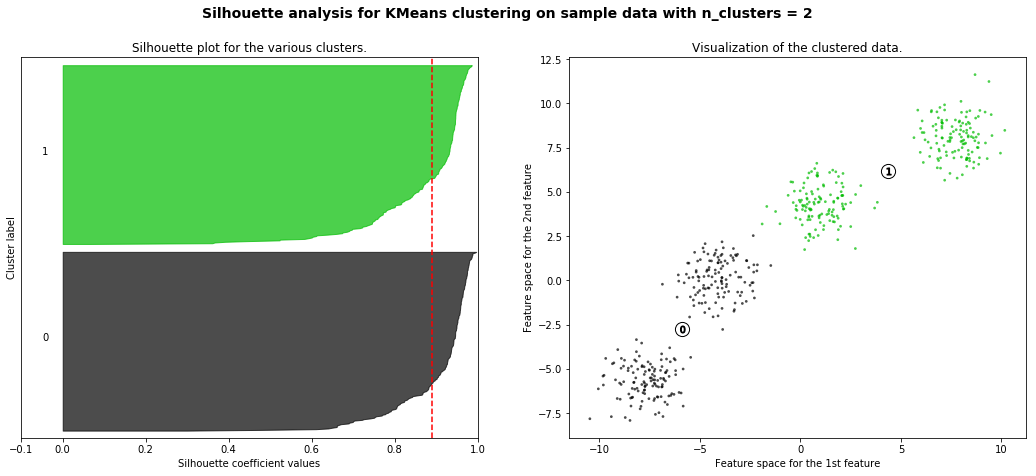

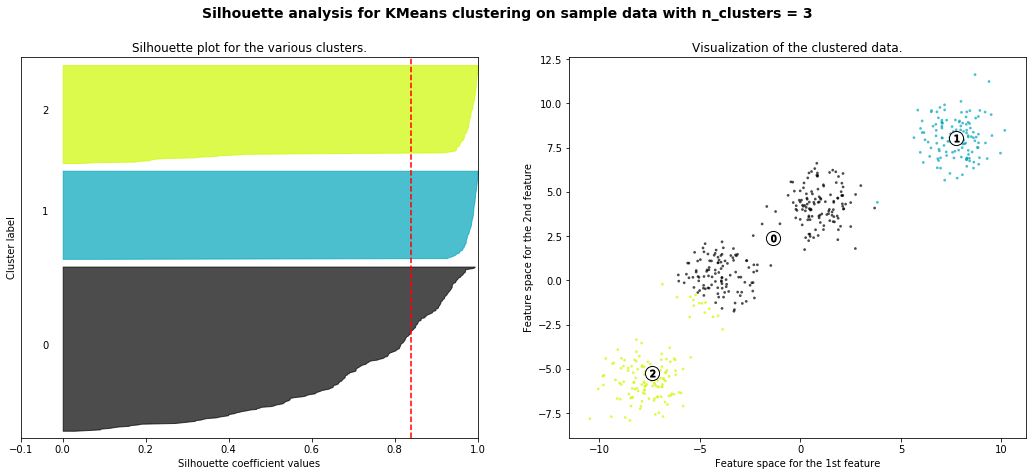

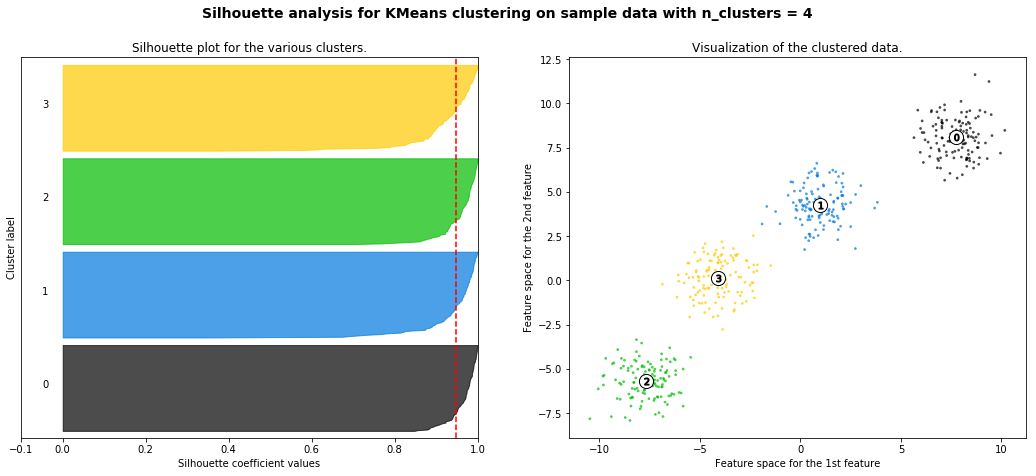

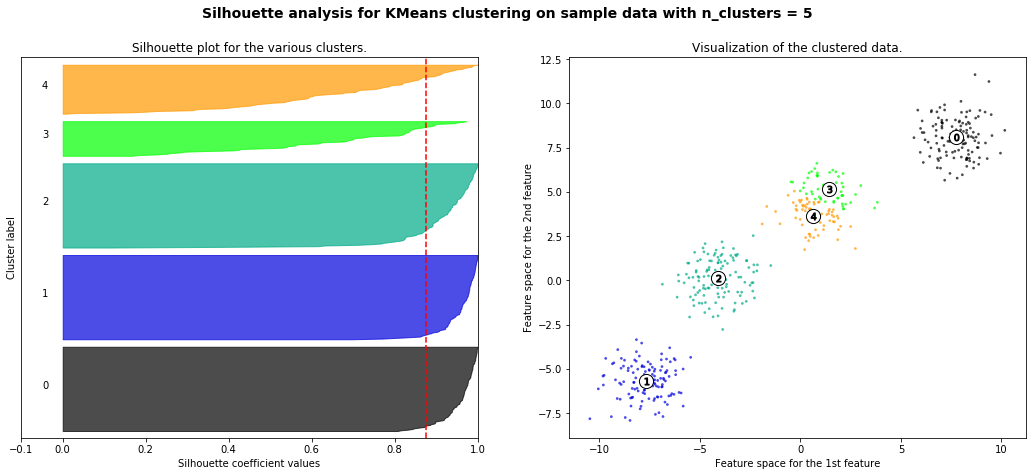

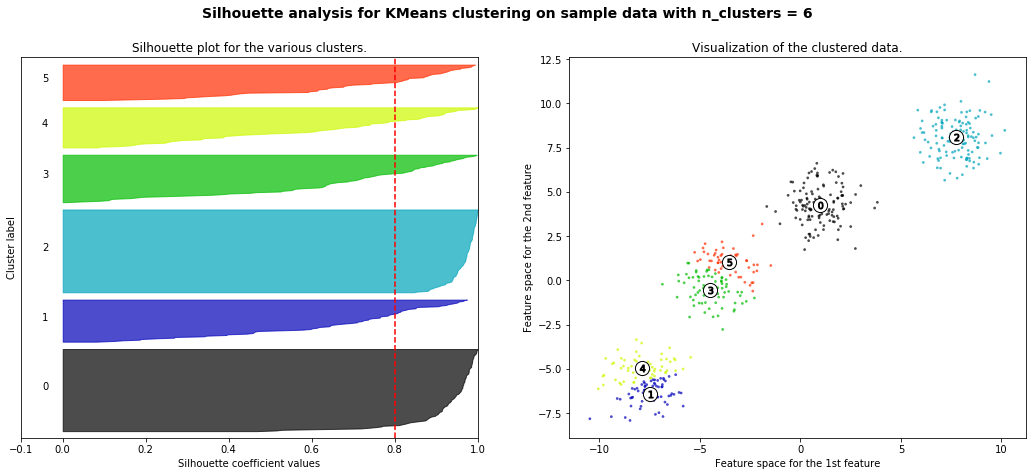

In [39]:
# get range of k values tested
k_range = %sql SELECT k FROM k_auto ORDER BY k;

# outer loop on k
# plot clusters for each k value
for n_clusters in k_range:
    
    # create table mapping each point to its centroid
    kval = n_clusters[0]
    %sql DROP TABLE IF EXISTS k_plot1;
    %sql CREATE TABLE k_plot1 AS (SELECT data.*, (madlib.closest_column(centroids, points, 'madlib.squared_dist_norm2')).column_id as cluster_id FROM km_sample1 as data, k_auto WHERE k=$kval);

    # get info from tables and reshape to np arrays    
    # number of points
    num_points_proxy= %sql SELECT COUNT(*) FROM k_plot1;
    num_points= num_points_proxy[0][0] 
    
    # points
    points_proxy = %sql SELECT points FROM k_plot1 ORDER BY pid;
    points = np.array(points_proxy).reshape(num_points,2) 
    
    # cluster id
    cluster_id_proxy = %sql SELECT cluster_id FROM k_plot1 ORDER BY pid;
    cluster_id = np.array(cluster_id_proxy).reshape(num_points)
    
    # centroids
    centroids_proxy = %sql SELECT centroids FROM k_auto WHERE k=$kval;
    centers = np.array(centroids_proxy[0][0]).reshape(kval,2)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = %sql SELECT silhouette FROM k_auto WHERE k=$kval;
    print("For n_clusters =", kval,
          "The average silhouette_score is :", silhouette_avg)
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
      
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (kval + 1) * 10])
    
    y_lower = 10
    
    # inner loop on number of centroids 
    for i in range(kval):

        %sql DROP TABLE IF EXISTS points_distr1;
        %sql SELECT * FROM madlib.simple_silhouette_points( 'km_sample1', 'points_distr1', 'pid', 'points', (SELECT centroids FROM k_auto WHERE k=$kval), 'madlib.squared_dist_norm2');
        ith_cluster_silhouette_values_proxy = %sql SELECT silh from points_distr1 WHERE centroid_id=$i ORDER BY silh;
        ith_cluster_silhouette_values = np.array(ith_cluster_silhouette_values_proxy).reshape(len(ith_cluster_silhouette_values_proxy))
        
        size_cluster_i_proxy = %sql SELECT COUNT(*) from points_distr1 WHERE centroid_id=$i;
        size_cluster_i = size_cluster_i_proxy[0][0]

        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / kval)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                  0, ith_cluster_silhouette_values, 
                  facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
           
    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    centroids = %sql SELECT centroid_id FROM points_distr1 ORDER BY pid;
    cluster_labels = np.array(centroids).reshape(len(centroids))
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / kval)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % kval),
                 fontsize=14, fontweight='bold')

plt.show()

Plot silhouette

5 rows affected.
5 rows affected.


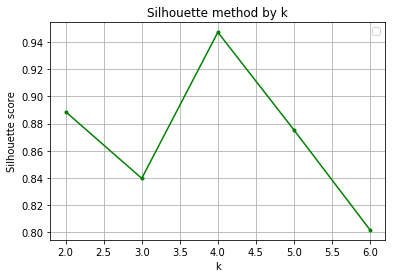

In [40]:
# get silhouette values for each k
k = %sql SELECT k FROM k_auto ORDER BY k;
silhouette = %sql SELECT silhouette FROM k_auto ORDER BY k;

#plot
plt.title('Silhouette method by k')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid(True,)
plt.plot(k, silhouette, 'g.-')
plt.legend()

Plot sum of squared errors

5 rows affected.


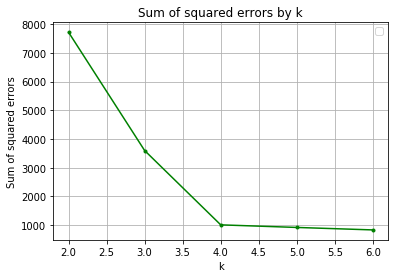

In [41]:
# get sum of squared error for each k
sse = %sql SELECT objective_fn FROM k_auto ORDER BY k;

#plot
plt.title('Sum of squared errors by k')
plt.xlabel('k')
plt.ylabel('Sum of squared errors')
plt.grid(True,)
plt.plot(k, sse, 'g.-')
plt.legend()

Plot elbow

5 rows affected.


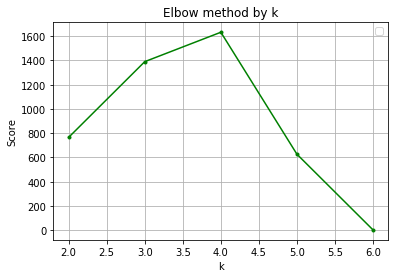

In [42]:
# get elbow values for each k
elbow = %sql SELECT elbow FROM k_auto ORDER BY k;

#plot
plt.title('Elbow method by k')
plt.xlabel('k')
plt.ylabel('Score')
plt.grid(True,)
plt.plot(k, elbow, 'g.-')
plt.legend()